# **_NBA Prediction Bot 2025 - 2026 Season_**

1 - Libraries

In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import requests
import nba_api

2 - Teams

In [4]:
from nba_api.stats.static import teams
import pandas as pd

# Build TEAM_ID -> TEAM_NAME lookup
team_lookup = {
    team['id']: team['full_name']
    for team in teams.get_teams()
}

# Example: apply to any dataframe that has TEAM_ID
# df['TEAM_NAME'] = df['TEAM_ID'].map(team_lookup)

# Demo printout
for k, v in team_lookup.items():
    print(f"{k} → {v}")


1610612737 → Atlanta Hawks
1610612738 → Boston Celtics
1610612739 → Cleveland Cavaliers
1610612740 → New Orleans Pelicans
1610612741 → Chicago Bulls
1610612742 → Dallas Mavericks
1610612743 → Denver Nuggets
1610612744 → Golden State Warriors
1610612745 → Houston Rockets
1610612746 → Los Angeles Clippers
1610612747 → Los Angeles Lakers
1610612748 → Miami Heat
1610612749 → Milwaukee Bucks
1610612750 → Minnesota Timberwolves
1610612751 → Brooklyn Nets
1610612752 → New York Knicks
1610612753 → Orlando Magic
1610612754 → Indiana Pacers
1610612755 → Philadelphia 76ers
1610612756 → Phoenix Suns
1610612757 → Portland Trail Blazers
1610612758 → Sacramento Kings
1610612759 → San Antonio Spurs
1610612760 → Oklahoma City Thunder
1610612761 → Toronto Raptors
1610612762 → Utah Jazz
1610612763 → Memphis Grizzlies
1610612764 → Washington Wizards
1610612765 → Detroit Pistons
1610612766 → Charlotte Hornets


BASELINE LOGISTIC REGRESSION

In [7]:
games = leaguegamefinder.LeagueGameFinder(season_nullable='2024-25', league_id_nullable='00').get_data_frames()[0]

# regular season only
games = games[games['SEASON_ID'].str.startswith('2')]

games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games = games.sort_values(['GAME_ID', 'TEAM_ID'])

# -------------------------
# 2. ADD OPPONENT POINTS (CRITICAL FIX)
# -------------------------
opp = games[['GAME_ID', 'TEAM_ID', 'PTS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED'}
)

games = games.merge(
    opp,
    on='GAME_ID'
)

games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# -------------------------
# 3. REST + BACK-TO-BACK
# -------------------------
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# -------------------------
# 4. TEAM STRENGTH (ROLLING NET)
# -------------------------
games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']

games['rolling_net'] = (
    games.groupby('TEAM_ID')['point_diff']
    .rolling(10, min_periods=3)
    .mean()
    .reset_index(level=0, drop=True)
)

# -------------------------
# 5. HOME / AWAY SPLIT
# -------------------------
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(
    away,
    on='GAME_ID',
    suffixes=('_home', '_away')
)

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
df['rest_diff'] = df['days_rest_home'] - df['days_rest_away']
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# -------------------------
# 6. FEATURE MATRIX
# -------------------------
feature_cols = [
    'rolling_net_home',
    'rolling_net_away',
    'b2b_home',
    'b2b_away',
    'rest_diff',
    'home_court'
]

df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['home_win']

# -------------------------
# 7. TRAIN MODEL
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


# -------------------------
# 8. PREDICT TODAY'S GAMES
# -------------------------
today = scoreboardv2.ScoreboardV2(
    game_date=datetime.today().strftime('%m/%d/%Y')
).get_data_frames()[0]

if today.empty:
    print("No games today.")
else:
    today_games = today[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    latest_strength = (
        games.sort_values('GAME_DATE')
        .groupby('TEAM_ID')
        .tail(1)[['TEAM_ID', 'rolling_net']]
    )

    today_games = today_games.merge(
        latest_strength,
        left_on='HOME_TEAM_ID',
        right_on='TEAM_ID'
    ).merge(
        latest_strength,
        left_on='VISITOR_TEAM_ID',
        right_on='TEAM_ID',
        suffixes=('_home', '_away')
    )

    today_games['home_court'] = 1
    today_games['b2b_home'] = 0
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_X = today_games[feature_cols]

    today_games['home_win_prob'] = model.predict_proba(today_X)[:, 1]

today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

output = (
    today_games[
        ['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']
    ]
    .sort_values('home_win_prob', ascending=False)
)

print(output)



                 HOME_TEAM               AWAY_TEAM  home_win_prob
8    Oklahoma City Thunder           Atlanta Hawks       0.788616
3               Miami Heat          Denver Nuggets       0.780534
12  Portland Trail Blazers        Dallas Mavericks       0.765589
11  Portland Trail Blazers        Dallas Mavericks       0.765589
1       Washington Wizards            Phoenix Suns       0.573881
6          Houston Rockets          Indiana Pacers       0.475881
5            Chicago Bulls  Minnesota Timberwolves       0.461340
4          Toronto Raptors           Orlando Magic       0.456731
10       San Antonio Spurs     Cleveland Cavaliers       0.263579
9        San Antonio Spurs     Cleveland Cavaliers       0.263579
7     New Orleans Pelicans         New York Knicks       0.157469
0        Charlotte Hornets         Milwaukee Bucks       0.109590
2            Brooklyn Nets   Golden State Warriors       0.061773


In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.7489539748953975
ROC AUC: 0.8090034965034966


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))




Accuracy: 0.7154811715481172
ROC AUC: 0.7843094405594405


In [17]:
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance)


            feature  importance
1  rolling_net_away    0.352552
0  rolling_net_home    0.294339
2          b2b_home    0.143544
4         rest_diff    0.126168
3          b2b_away    0.083397
5        home_court    0.000000


training data from 2022


In [6]:
def load_season(season):
    df = leaguegamefinder.LeagueGameFinder(
        season_nullable=season,
        league_id_nullable='00'
    ).get_data_frames()[0]
    df = df[df['SEASON_ID'].str.startswith('2')]
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
    return df

games = pd.concat([
    load_season('2023-24'),
    load_season('2024-25'),
    load_season('2025-26')
])

games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

# -------------------------
# 2. SEASON WEIGHTS
# -------------------------
games['season_weight'] = np.where(
    games['SEASON_ID'].str.contains('2025'),
    1.5,   # current season higher weight
    1.0    # last season
)

# -------------------------
# 3. ADD OPPONENT POINTS
# -------------------------
opp = games[['GAME_ID', 'TEAM_ID', 'PTS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED'}
)
games = games.merge(opp, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# -------------------------
# 4. REST + BACK-TO-BACK
# -------------------------
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])
games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# -------------------------
# 5. TEAM STRENGTH (ROLLING NET)
# -------------------------
games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']
games['rolling_net'] = (
    games.groupby('TEAM_ID')['point_diff']
    .rolling(10, min_periods=3)
    .mean()
    .reset_index(level=0, drop=True)
)

# -------------------------
# 6. HOME / AWAY SPLIT
# -------------------------
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(
    away,
    on='GAME_ID',
    suffixes=('_home', '_away')
)

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
df['rest_diff'] = df['days_rest_home'] - df['days_rest_away']
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# -------------------------
# 7. SAMPLE WEIGHTS
# -------------------------
df['sample_weight'] = (df['season_weight_home'] + df['season_weight_away']) / 2

# -------------------------
# 8. FEATURE MATRIX
# -------------------------
feature_cols = [
    'rolling_net_home',
    'rolling_net_away',
    'b2b_home',
    'b2b_away',
    'rest_diff',
    'home_court'
]

df = df.dropna(subset=feature_cols)
X = df[feature_cols]
y = df['home_win']
weights = df['sample_weight']

# -------------------------
# 9. TRAIN MODEL
# -------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, shuffle=False
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train, sample_weight=w_train)

# -------------------------
# 10. PREDICT TODAY'S GAMES
# -------------------------
today = scoreboardv2.ScoreboardV2(
    game_date=datetime.today().strftime('%m/%d/%Y')
).get_data_frames()[0]

if today.empty:
    print("No games today.")
else:
    today_games = today[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    latest_strength = (
        games.sort_values('GAME_DATE')
        .groupby('TEAM_ID')
        .tail(1)[['TEAM_ID', 'rolling_net']]
    )

    today_games = today_games.merge(
        latest_strength,
        left_on='HOME_TEAM_ID',
        right_on='TEAM_ID'
    ).merge(
        latest_strength,
        left_on='VISITOR_TEAM_ID',
        right_on='TEAM_ID',
        suffixes=('_home', '_away')
    )

    today_games['home_court'] = 1
    today_games['b2b_home'] = 0
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_X = today_games[feature_cols]
    today_games['home_win_prob'] = model.predict_proba(today_X)[:, 1]

    # Map team IDs to team names (requires team_lookup dict)
    today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
    today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

    output = today_games[['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']].sort_values(
        'home_win_prob', ascending=False
    )
    print(output)

                 HOME_TEAM               AWAY_TEAM  home_win_prob
8    Oklahoma City Thunder           Atlanta Hawks       0.909430
6          Houston Rockets          Indiana Pacers       0.878823
10       San Antonio Spurs     Cleveland Cavaliers       0.846441
9        San Antonio Spurs     Cleveland Cavaliers       0.846441
0        Charlotte Hornets         Milwaukee Bucks       0.737315
4          Toronto Raptors           Orlando Magic       0.635221
2            Brooklyn Nets   Golden State Warriors       0.622301
7     New Orleans Pelicans         New York Knicks       0.550977
1       Washington Wizards            Phoenix Suns       0.509826
12  Portland Trail Blazers        Dallas Mavericks       0.468433
11  Portland Trail Blazers        Dallas Mavericks       0.468433
3               Miami Heat          Denver Nuggets       0.468023
5            Chicago Bulls  Minnesota Timberwolves       0.348780


In [6]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.7850953206239168
ROC AUC: 0.8180664543029549


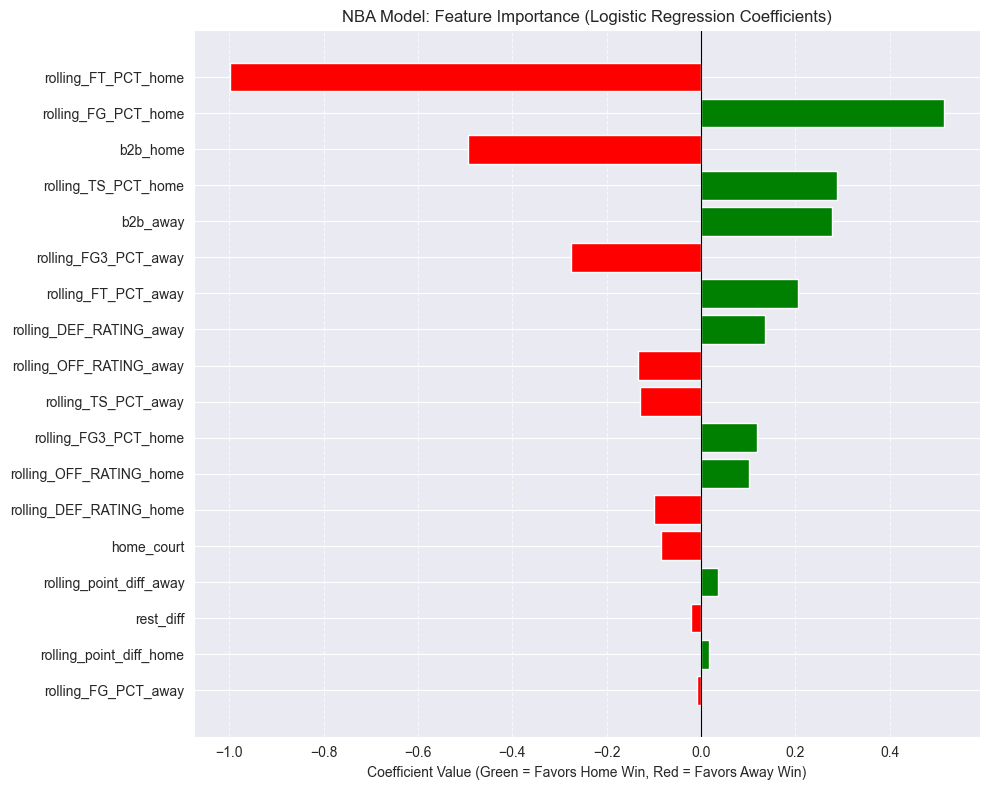

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------
# FEATURE IMPORTANCE
# -------------------------
def plot_feature_importance(model, feature_names):
    # Get the coefficients (weights) from the logistic regression model
    # For LogisticRegression, importance is represented by the coefficients
    importance = model.coef_[0]

    # Create a DataFrame for easy plotting
    feat_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort by absolute value to see the most impactful features at the top
    feat_importance['Abs_Importance'] = feat_importance['Importance'].abs()
    feat_importance = feat_importance.sort_values(by='Abs_Importance', ascending=True)

    # Plotting
    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'green' for x in feat_importance['Importance']]

    plt.barh(feat_importance['Feature'], feat_importance['Importance'], color=colors)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

    plt.title('NBA Model: Feature Importance (Logistic Regression Coefficients)')
    plt.xlabel('Coefficient Value (Green = Favors Home Win, Red = Favors Away Win)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




In [26]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [8]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import datetime

# 1. LOAD DATA (Consolidated for 2023-24, 2024-25, and 2025-26)
def load_season(season):
    df = leaguegamefinder.LeagueGameFinder(
        season_nullable=season,
        league_id_nullable='00'
    ).get_data_frames()[0]

    # Filter for regular season IDs and fix dates
    df = df[df['SEASON_ID'].str.startswith('2')].copy()
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Calculate True Shooting Percentage
    # TS% = PTS / (2 * (FGA + 0.44 * FTA))
    df['TS_PCT'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))

    # FT_PCT, FG_PCT, and FG3_PCT are already in the dataframe from NBA API
    return df

games = pd.concat([
    load_season('2023-24'),
    load_season('2024-25'),
    load_season('2025-26')
])

games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

# 2. SEASON WEIGHTS
games['season_weight'] = np.where(
    games['SEASON_ID'].str.contains('2025'),
    1.5,   # current season higher weight
    1.0    # last season
)

# 3. ADD OPPONENT POINTS
opp = games[['GAME_ID', 'TEAM_ID', 'PTS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED'}
)
games = games.merge(opp, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# 4. REST + BACK-TO-BACK
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])
games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# 5. TEAM STRENGTH (ROLLING STATS)
games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']

# Define the new stats to track (Net Rating, TS, FG, 3PT, and FT)
stats_to_roll = ['point_diff', 'TS_PCT', 'FG_PCT', 'FG3_PCT', 'FT_PCT']

for stat in stats_to_roll:
    games[f'rolling_{stat}'] = (
        games.groupby('TEAM_ID')[stat]
        .rolling(10, min_periods=3)
        .mean()
        .reset_index(level=0, drop=True)
    )

# 6. HOME / AWAY SPLIT
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(
    away,
    on='GAME_ID',
    suffixes=('_home', '_away')
)

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
df['rest_diff'] = df['days_rest_home'] - df['days_rest_away']
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# 7. SAMPLE WEIGHTS
df['sample_weight'] = (df['season_weight_home'] + df['season_weight_away']) / 2

# 8. FEATURE MATRIX (Updated with FT_PCT)
feature_cols = [
    'rolling_point_diff_home', 'rolling_point_diff_away',
    'rolling_TS_PCT_home', 'rolling_TS_PCT_away',
    'rolling_FG_PCT_home', 'rolling_FG_PCT_away',
    'rolling_FG3_PCT_home', 'rolling_FG3_PCT_away',
    'rolling_FT_PCT_home', 'rolling_FT_PCT_away',
    'b2b_home', 'b2b_away',
    'rest_diff', 'home_court'
]

df = df.dropna(subset=feature_cols)
X = df[feature_cols]
y = df['home_win']
weights = df['sample_weight']

# 9. TRAIN MODEL
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, shuffle=False
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train, sample_weight=w_train)

# 10. PREDICT TODAY'S GAMES
today = scoreboardv2.ScoreboardV2(
    game_date=datetime.today().strftime('%m/%d/%Y')
).get_data_frames()[0]

if today.empty:
    print("No games today.")
else:
    today_games = today[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    # Get latest rolling averages for all features
    latest_cols = ['TEAM_ID', 'rolling_point_diff', 'rolling_TS_PCT',
                   'rolling_FG_PCT', 'rolling_FG3_PCT', 'rolling_FT_PCT']
    latest_strength = (
        games.sort_values('GAME_DATE')
        .groupby('TEAM_ID')
        .tail(1)[latest_cols]
    )

    today_games = today_games.merge(
        latest_strength,
        left_on='HOME_TEAM_ID',
        right_on='TEAM_ID'
    ).merge(
        latest_strength,
        left_on='VISITOR_TEAM_ID',
        right_on='TEAM_ID',
        suffixes=('_home', '_away')
    )

    # Note: For simplicity, b2b and rest are set to 0 here;
    # to be fully accurate, you would calculate these from the 'games' df
    today_games['home_court'] = 1
    today_games['b2b_home'] = 0
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_X = today_games[feature_cols]
    today_games['home_win_prob'] = model.predict_proba(today_X)[:, 1]

    # Map team names (requires team_lookup dictionary to be defined)
    today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
    today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

    output = today_games[['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']].sort_values(
        'home_win_prob', ascending=False
    )
    print(output)

                 HOME_TEAM               AWAY_TEAM  home_win_prob
8    Oklahoma City Thunder           Atlanta Hawks       0.907820
6          Houston Rockets          Indiana Pacers       0.885585
10       San Antonio Spurs     Cleveland Cavaliers       0.845935
9        San Antonio Spurs     Cleveland Cavaliers       0.845935
0        Charlotte Hornets         Milwaukee Bucks       0.740839
4          Toronto Raptors           Orlando Magic       0.627085
2            Brooklyn Nets   Golden State Warriors       0.617749
7     New Orleans Pelicans         New York Knicks       0.536785
1       Washington Wizards            Phoenix Suns       0.512363
12  Portland Trail Blazers        Dallas Mavericks       0.474249
11  Portland Trail Blazers        Dallas Mavericks       0.474249
3               Miami Heat          Denver Nuggets       0.455109
5            Chicago Bulls  Minnesota Timberwolves       0.351960


In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.7816291161178509
ROC AUC: 0.8187657006707587


In [11]:
plot_feature_importance(model, feature_cols)

NameError: name 'plot_feature_importance' is not defined

In [9]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import datetime

# 1. LOAD DATA (Consolidated for 2023-24, 2024-25, and 2025-26)
def load_season(season):
    df = leaguegamefinder.LeagueGameFinder(
        season_nullable=season,
        league_id_nullable='00'
    ).get_data_frames()[0]

    df = df[df['SEASON_ID'].str.startswith('2')].copy()
    df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

    # Base Shooting Stats
    df['TS_PCT'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))

    # Estimate Possessions for Ratings
    # Formula: 0.96 * (FGA + TOV + 0.44 * FTA - OREB)
    df['POSS'] = 0.96 * (df['FGA'] + df['TOV'] + 0.44 * df['FTA'] - df['OREB'])

    # Offensive Rating (Points per 100 possessions)
    df['OFF_RATING'] = (df['PTS'] / df['POSS']) * 100

    return df

games = pd.concat([
    load_season('2023-24'),
    load_season('2024-25'),
    load_season('2025-26')
])

games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

# 2. SEASON WEIGHTS
games['season_weight'] = np.where(
    games['SEASON_ID'].str.contains('2025'),
    1.5,
    1.0
)

# 3. ADD OPPONENT STATS (For Defensive Rating)
opp = games[['GAME_ID', 'TEAM_ID', 'PTS', 'POSS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED', 'POSS': 'OPP_POSS'}
)
games = games.merge(opp, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# Calculate Defensive Rating (Opponent points per 100 possessions)
# We use the average of both teams' possessions for a more stable estimate
df_poss = (games['POSS'] + games['OPP_POSS']) / 2
games['DEF_RATING'] = (games['PTS_ALLOWED'] / df_poss) * 100

# 4. REST + BACK-TO-BACK
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])
games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# 5. TEAM STRENGTH (ROLLING STATS)
games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']

stats_to_roll = [
    'point_diff', 'TS_PCT', 'FG_PCT', 'FG3_PCT',
    'FT_PCT', 'OFF_RATING', 'DEF_RATING'
]

for stat in stats_to_roll:
    games[f'rolling_{stat}'] = (
        games.groupby('TEAM_ID')[stat]
        .rolling(10, min_periods=3)
        .mean()
        .reset_index(level=0, drop=True)
    )

# 6. HOME / AWAY SPLIT
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(
    away,
    on='GAME_ID',
    suffixes=('_home', '_away')
)

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
df['rest_diff'] = df['days_rest_home'] - df['days_rest_away']
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# 7. SAMPLE WEIGHTS
df['sample_weight'] = (df['season_weight_home'] + df['season_weight_away']) / 2

# 8. FEATURE MATRIX (Updated with Off/Def Rating)
feature_cols = [
    'rolling_point_diff_home', 'rolling_point_diff_away',
    'rolling_TS_PCT_home', 'rolling_TS_PCT_away',
    'rolling_FG_PCT_home', 'rolling_FG_PCT_away',
    'rolling_FG3_PCT_home', 'rolling_FG3_PCT_away',
    'rolling_FT_PCT_home', 'rolling_FT_PCT_away',
    'rolling_OFF_RATING_home', 'rolling_OFF_RATING_away',
    'rolling_DEF_RATING_home', 'rolling_DEF_RATING_away',
    'b2b_home', 'b2b_away',
    'rest_diff', 'home_court'
]

df = df.dropna(subset=feature_cols)
X = df[feature_cols]
y = df['home_win']
weights = df['sample_weight']

# 9. TRAIN MODEL
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, shuffle=False
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train, sample_weight=w_train)

# 10. PREDICT TODAY'S GAMES
today_str = datetime.today().strftime('%m/%d/%Y')
today = scoreboardv2.ScoreboardV2(game_date=today_str).get_data_frames()[0]

if today.empty:
    print("No games today.")
else:
    today_games = today[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    latest_cols = ['TEAM_ID'] + [f'rolling_{s}' for s in stats_to_roll]
    latest_strength = (
        games.sort_values('GAME_DATE')
        .groupby('TEAM_ID')
        .tail(1)[latest_cols]
    )

    today_games = today_games.merge(
        latest_strength, left_on='HOME_TEAM_ID', right_on='TEAM_ID'
    ).merge(
        latest_strength, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', suffixes=('_home', '_away')
    )

    today_games['home_court'] = 1
    today_games['b2b_home'] = 0
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_X = today_games[feature_cols]
    today_games['home_win_prob'] = model.predict_proba(today_X)[:, 1]

    today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
    today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

    output = today_games[['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']].sort_values(
        'home_win_prob', ascending=False
    )
    print(output)

                HOME_TEAM              AWAY_TEAM  home_win_prob
1   Oklahoma City Thunder     Philadelphia 76ers       0.781392
5      Los Angeles Lakers       Sacramento Kings       0.471518
4    Los Angeles Clippers        Detroit Pistons       0.416919
0         Toronto Raptors  Golden State Warriors       0.260020
2      Washington Wizards      Memphis Grizzlies       0.234992
3  Portland Trail Blazers         Boston Celtics       0.155358


In [102]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.7708333333333334
ROC AUC: 0.8127894873796514


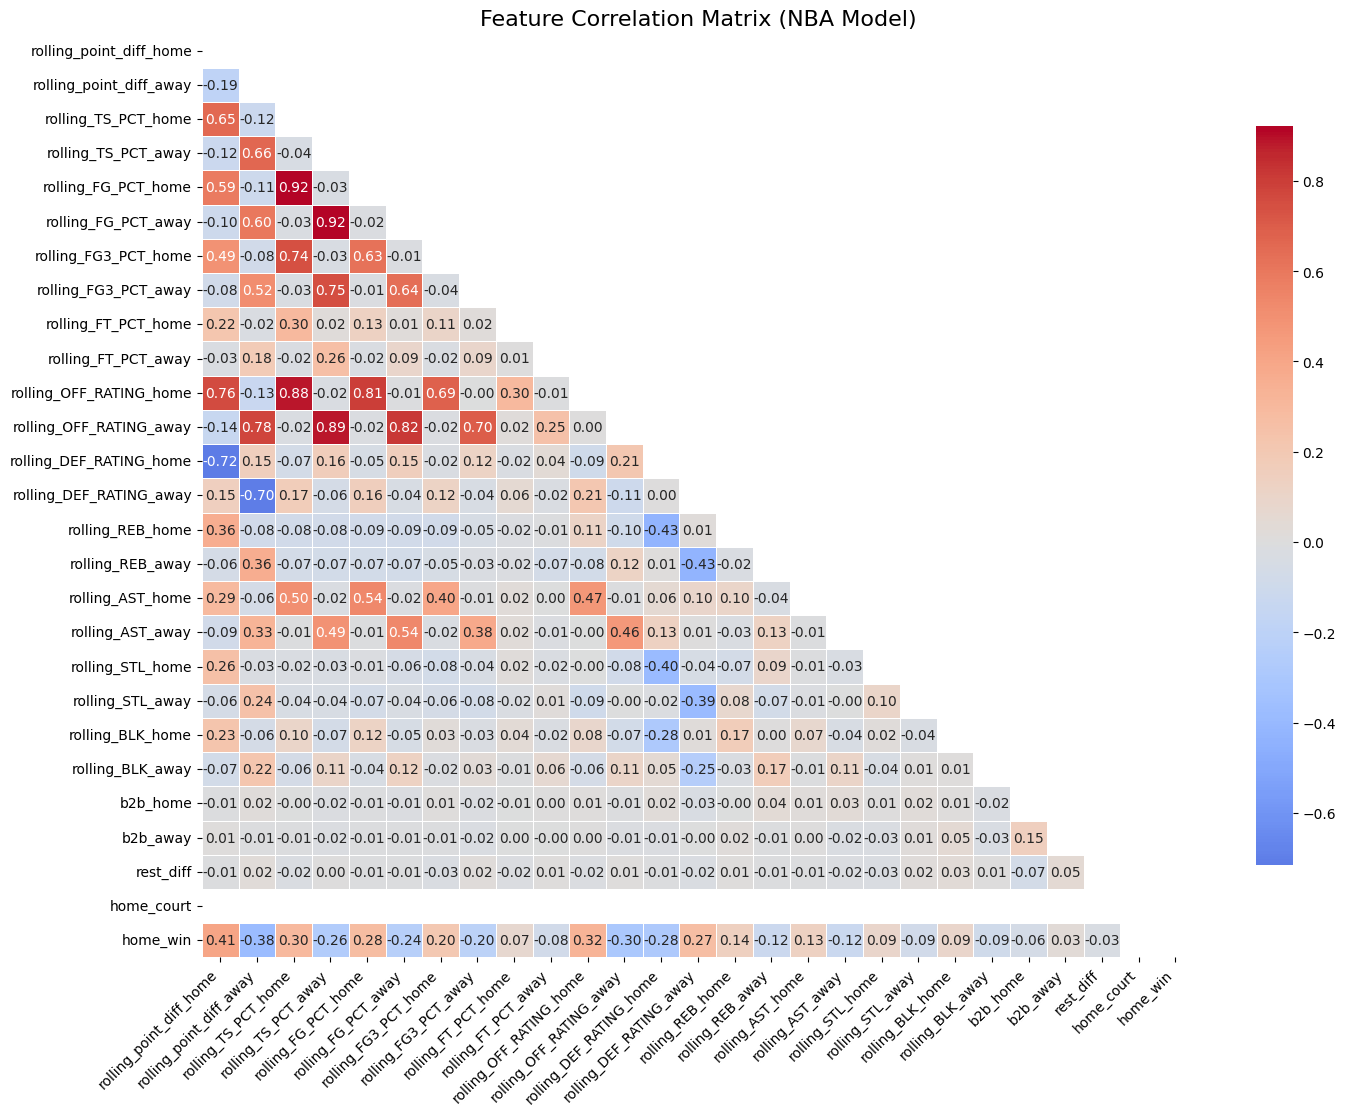

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------
# CORRELATION MATRIX
# -------------------------
def plot_correlation_matrix(df, features, target):
    # Combine features and target for the correlation calculation
    corr_data = df[features + [target]]

    # Calculate the Pearson correlation
    corr_matrix = corr_data.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(16, 12))

    # Create a mask for the upper triangle (optional, for cleaner look)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Draw the heatmap
    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        linewidths=.5,
        cbar_kws={"shrink": .8}
    )

    plt.title('Feature Correlation Matrix (NBA Model)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Execute the plot
plot_correlation_matrix(df, feature_cols, 'home_win')

logistic regression + offensive rating, defensive rating


In [49]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import datetime

# 1. FETCH DATA
games = leaguegamefinder.LeagueGameFinder(
    season_nullable='2024-25',
    league_id_nullable='00'
).get_data_frames()[0]

games = games[games['SEASON_ID'].str.startswith('2')]
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])

# -------------------------
# 2. CALCULATE OFF/DEF RATING
# -------------------------
# Calculate Possessions (Standard NBA Estimate)
games['POSS'] = 0.96 * (games['FGA'] + games['TOV'] + 0.44 * games['FTA'] - games['OREB'])

# Offensive Rating: Points scored per 100 possessions
games['OFF_RATING'] = (games['PTS'] / games['POSS']) * 100

# To get Defensive Rating, we need the opponent's points and possessions
opp_stats = games[['GAME_ID', 'TEAM_ID', 'PTS', 'POSS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'OPP_PTS', 'POSS': 'OPP_POSS'}
)

games = games.merge(opp_stats, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# Defensive Rating: Points allowed per 100 opponent possessions
games['DEF_RATING'] = (games['OPP_PTS'] / games['OPP_POSS']) * 100

# -------------------------
# 3. REST + ROLLING STATS
# -------------------------
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

# Rest calculations
games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# Rolling Ratings (10-game window)
games['rolling_off'] = games.groupby('TEAM_ID')['OFF_RATING'].transform(lambda x: x.rolling(10, min_periods=3).mean())
games['rolling_def'] = games.groupby('TEAM_ID')['DEF_RATING'].transform(lambda x: x.rolling(10, min_periods=3).mean())
games['point_diff'] = games['PTS'] - games['OPP_PTS']
games['rolling_net'] = games.groupby('TEAM_ID')['point_diff'].transform(lambda x: x.rolling(10, min_periods=3).mean())

# -------------------------
# 4. MERGE HOME/AWAY SPLITS
# -------------------------
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(away, on='GAME_ID', suffixes=('_home', '_away'))

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
df['rest_diff'] = df['days_rest_home'].fillna(3) - df['days_rest_away'].fillna(3)
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# -------------------------
# 5. FEATURE MATRIX & MODEL
# -------------------------
feature_cols = [
    'rolling_net_home', 'rolling_net_away',
    'rolling_off_home', 'rolling_off_away',
    'rolling_def_home', 'rolling_def_away',
    'b2b_home', 'b2b_away', 'rest_diff', 'home_court'
]

df = df.dropna(subset=feature_cols)
X = df[feature_cols]
y = df['home_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# -------------------------
# 6. PREDICT TODAY
# -------------------------
today_data = scoreboardv2.ScoreboardV2(game_date=datetime.today().strftime('%m/%d/%Y')).get_data_frames()[0]

if not today_data.empty:
    today_games = today_data[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    # Get the most recent rolling stats for each team
    latest_stats = games.sort_values('GAME_DATE').groupby('TEAM_ID').tail(1)[
        ['TEAM_ID', 'rolling_net', 'rolling_off', 'rolling_def']
    ]

    today_games = today_games.merge(latest_stats, left_on='HOME_TEAM_ID', right_on='TEAM_ID') \
                             .merge(latest_stats, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', suffixes=('_home', '_away'))

    today_games['home_court'] = 1
    today_games['b2b_home'] = 0
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_games['home_win_prob'] = model.predict_proba(today_games[feature_cols])[:, 1]

    # Optional: map team names if you have the team_lookup dict
    # today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
    # today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

output = (
    today_games[
        ['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']
    ]
    .sort_values('home_win_prob', ascending=False)
)

print(output)


                HOME_TEAM            AWAY_TEAM  home_win_prob
7  Minnesota Timberwolves        Brooklyn Nets       0.944856
8       San Antonio Spurs            Utah Jazz       0.857923
0        Sacramento Kings     Dallas Mavericks       0.837723
2    New Orleans Pelicans         Phoenix Suns       0.695364
4              Miami Heat       Indiana Pacers       0.676836
1           Orlando Magic       Denver Nuggets       0.659639
6         Houston Rockets  Cleveland Cavaliers       0.621184
5           Chicago Bulls      Milwaukee Bucks       0.577316
3           Atlanta Hawks      New York Knicks       0.568210


logistic regression 2020 -

In [66]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import datetime

# -------------------------
# 1. FETCH MULTI-SEASON DATA
# -------------------------
seasons = ['2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']
all_games = []

for season in seasons:
    print(f"Fetching season: {season}...")
    season_data = leaguegamefinder.LeagueGameFinder(
        season_nullable=season,
        league_id_nullable='00' # NBA only
    ).get_data_frames()[0]
    all_games.append(season_data)

games = pd.concat(all_games, ignore_index=True)

# Filter for Regular Season games only
# Regular season IDs start with '2' (e.g., 22024)
games = games[games['SEASON_ID'].str.endswith(tuple([s[-2:] for s in seasons]))]
games = games[games['SEASON_ID'].str.startswith('2')]

games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])

# -------------------------
# 2. CALCULATE OFF/DEF RATING
# -------------------------
# Calculate Possessions (Standard NBA Estimate)
games['POSS'] = 0.96 * (games['FGA'] + games['TOV'] + 0.44 * games['FTA'] - games['OREB'])

# Offensive Rating
games['OFF_RATING'] = (games['PTS'] / games['POSS']) * 100

# Opponent Stats for Defensive Rating
opp_stats = games[['GAME_ID', 'TEAM_ID', 'PTS', 'POSS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'OPP_PTS', 'POSS': 'OPP_POSS'}
)

games = games.merge(opp_stats, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# Defensive Rating
games['DEF_RATING'] = (games['OPP_PTS'] / games['OPP_POSS']) * 100

# -------------------------
# 3. REST + ROLLING STATS
# -------------------------
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

# Rest calculations
games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# Rolling Ratings (10-game window)
games['rolling_off'] = games.groupby('TEAM_ID')['OFF_RATING'].transform(lambda x: x.rolling(10, min_periods=3).mean())
games['rolling_def'] = games.groupby('TEAM_ID')['DEF_RATING'].transform(lambda x: x.rolling(10, min_periods=3).mean())
games['point_diff'] = games['PTS'] - games['OPP_PTS']
games['rolling_net'] = games.groupby('TEAM_ID')['point_diff'].transform(lambda x: x.rolling(10, min_periods=3).mean())

# -------------------------
# 4. MERGE HOME/AWAY SPLITS
# -------------------------
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(away, on='GAME_ID', suffixes=('_home', '_away'))

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
# Fillna with 3 to assume neutral rest for the first games of the dataset
df['rest_diff'] = df['days_rest_home'].fillna(3) - df['days_rest_away'].fillna(3)
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# -------------------------
# 5. FEATURE MATRIX & MODEL
# -------------------------
feature_cols = [
    'rolling_net_home', 'rolling_net_away',
    'rolling_off_home', 'rolling_off_away',
    'rolling_def_home', 'rolling_def_away',
    'b2b_home', 'b2b_away', 'rest_diff', 'home_court'
]

df = df.dropna(subset=feature_cols)
X = df[feature_cols]
y = df['home_win']

# Use shuffle=False because this is time-series data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

# -------------------------
# 6. PREDICT TODAY
# -------------------------
# Make sure team_lookup is defined elsewhere in your script
# team_lookup = { ... }

today_data = scoreboardv2.ScoreboardV2(game_date=datetime.today().strftime('%m/%d/%Y')).get_data_frames()[0]

if not today_data.empty:
    today_games = today_data[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    # Get the absolute latest rolling stats for each team
    latest_stats = games.sort_values('GAME_DATE').groupby('TEAM_ID').tail(1)[
        ['TEAM_ID', 'rolling_net', 'rolling_off', 'rolling_def']
    ]

    today_games = today_games.merge(latest_stats, left_on='HOME_TEAM_ID', right_on='TEAM_ID') \
                             .merge(latest_stats, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', suffixes=('_home', '_away'))

    today_games['home_court'] = 1
    today_games['b2b_home'] = 0 # You could calculate these by checking yesterday's schedule
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_games['home_win_prob'] = model.predict_proba(today_games[feature_cols])[:, 1]

    today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
    today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

    output = (
        today_games[['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']]
        .sort_values('home_win_prob', ascending=False)
    )
    print(output)
else:
    print("No games scheduled for today.")

Fetching season: 2019-20...
Fetching season: 2020-21...
Fetching season: 2021-22...
Fetching season: 2022-23...
Fetching season: 2023-24...
Fetching season: 2024-25...
                HOME_TEAM            AWAY_TEAM  home_win_prob
7  Minnesota Timberwolves        Brooklyn Nets       0.939920
0        Sacramento Kings     Dallas Mavericks       0.818611
8       San Antonio Spurs            Utah Jazz       0.814316
4              Miami Heat       Indiana Pacers       0.673250
1           Orlando Magic       Denver Nuggets       0.666877
2    New Orleans Pelicans         Phoenix Suns       0.624352
6         Houston Rockets  Cleveland Cavaliers       0.604739
3           Atlanta Hawks      New York Knicks       0.564021
5           Chicago Bulls      Milwaukee Bucks       0.557253


In [67]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.695142378559464
ROC AUC: 0.7500547911847071


In [84]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from datetime import datetime

# 1. FETCH DATA
games = leaguegamefinder.LeagueGameFinder(
    season_nullable='2024-25',
    league_id_nullable='00'
).get_data_frames()[0]

# regular season only
games = games[games['SEASON_ID'].str.startswith('2')]

games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games = games.sort_values(['GAME_ID', 'TEAM_ID'])

# -------------------------
# 2. ADD OPPONENT POINTS (CRITICAL FIX)
# -------------------------
opp = games[['GAME_ID', 'TEAM_ID', 'PTS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED'}
)

games = games.merge(opp, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

# -------------------------
# NEW: HEAD-TO-HEAD WIN COUNT
# -------------------------
# Sort by date to ensure cumulative sums respect chronological order
games = games.sort_values('GAME_DATE')

# Calculate if the team won that specific game
games['is_win'] = (games['WL'] == 'W').astype(int)

# Cumulative wins for Team A against Team B, shifted so it's "wins prior to this game"
games['h2h_wins'] = (
    games.groupby(['TEAM_ID', 'OPP_TEAM_ID'])['is_win']
    .transform(lambda x: x.cumsum().shift(1).fillna(0))
)

# -------------------------
# 3. REST + BACK-TO-BACK
# -------------------------
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])

games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

# -------------------------
# 4. TEAM STRENGTH (ROLLING NET)
# -------------------------
games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']

games['rolling_net'] = (
    games.groupby('TEAM_ID')['point_diff']
    .rolling(10, min_periods=3)
    .mean()
    .reset_index(level=0, drop=True)
)

# -------------------------
# 5. HOME / AWAY SPLIT
# -------------------------
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(
    away,
    on='GAME_ID',
    suffixes=('_home', '_away')
)

df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['home_court'] = 1
df['rest_diff'] = df['days_rest_home'] - df['days_rest_away']
df['b2b_home'] = df['back_to_back_home']
df['b2b_away'] = df['back_to_back_away']

# Head-to-head feature: Home team's historical wins vs Away, and vice versa
df['h2h_wins_home'] = df['h2h_wins_home']
df['h2h_wins_away'] = df['h2h_wins_away']

# -------------------------
# 6. FEATURE MATRIX
# -------------------------
feature_cols = [
    'rolling_net_home',
    'rolling_net_away',
    'h2h_wins_home',   # Added
    'h2h_wins_away',   # Added
    'b2b_home',
    'b2b_away',
    'rest_diff',
    'home_court'
]

df = df.dropna(subset=feature_cols)

X = df[feature_cols]
y = df['home_win']

# -------------------------
# 7. TRAIN MODEL
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# -------------------------
# 8. PREDICT TODAY'S GAMES
# -------------------------
# -------------------------
# 8. PREDICT TODAY'S GAMES
# -------------------------
today = scoreboardv2.ScoreboardV2(
    game_date=datetime.today().strftime('%m/%d/%Y')
).get_data_frames()[0]

if today.empty:
    print("No games today.")
else:
    today_games = today[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    # Get latest rolling net strength
    latest_strength = (
        games.sort_values('GAME_DATE')
        .groupby('TEAM_ID')
        .tail(1)[['TEAM_ID', 'rolling_net']]
    )

    # Get total H2H wins for each matchup up to today
    total_h2h = (
        games.groupby(['TEAM_ID', 'OPP_TEAM_ID'])['is_win']
        .sum()
        .reset_index()
        .rename(columns={'is_win': 'h2h_wins'})
    )

    today_games = today_games.merge(
        latest_strength,
        left_on='HOME_TEAM_ID',
        right_on='TEAM_ID'
    ).merge(
        latest_strength,
        left_on='VISITOR_TEAM_ID',
        right_on='TEAM_ID',
        suffixes=('_home', '_away')
    )

    # Merge H2H wins for the home team
    today_games = today_games.merge(
        total_h2h,
        left_on=['HOME_TEAM_ID', 'VISITOR_TEAM_ID'],
        right_on=['TEAM_ID', 'OPP_TEAM_ID'],
        how='left'
    ).rename(columns={'h2h_wins': 'h2h_wins_home'})

    # Remove redundant columns safely (errors='ignore' prevents the KeyError)
    cols_to_drop = ['TEAM_ID_x', 'TEAM_ID_y', 'TEAM_ID', 'OPP_TEAM_ID']
    today_games = today_games.drop(columns=cols_to_drop, errors='ignore')

    # Merge H2H wins for the away team
    today_games = today_games.merge(
        total_h2h,
        left_on=['VISITOR_TEAM_ID', 'HOME_TEAM_ID'],
        right_on=['TEAM_ID', 'OPP_TEAM_ID'],
        how='left'
    ).rename(columns={'h2h_wins': 'h2h_wins_away'})

    # Remove redundant columns safely again
    today_games = today_games.drop(columns=cols_to_drop, errors='ignore')

    # Fill NaN for teams that haven't played each other yet this season
    today_games[['h2h_wins_home', 'h2h_wins_away']] = today_games[['h2h_wins_home', 'h2h_wins_away']].fillna(0)

    today_games['home_court'] = 1
    today_games['b2b_home'] = 0
    today_games['b2b_away'] = 0
    today_games['rest_diff'] = 0

    today_X = today_games[feature_cols]
    today_games['home_win_prob'] = model.predict_proba(today_X)[:, 1]

# Map names and output
today_games['HOME_TEAM'] = today_games['HOME_TEAM_ID'].map(team_lookup)
today_games['AWAY_TEAM'] = today_games['VISITOR_TEAM_ID'].map(team_lookup)

output = (
    today_games[['HOME_TEAM', 'AWAY_TEAM', 'home_win_prob']]
    .sort_values('home_win_prob', ascending=False)
)

print(output)

                HOME_TEAM            AWAY_TEAM  home_win_prob
7  Minnesota Timberwolves        Brooklyn Nets       0.958478
8       San Antonio Spurs            Utah Jazz       0.899413
0        Sacramento Kings     Dallas Mavericks       0.896167
2    New Orleans Pelicans         Phoenix Suns       0.746749
4              Miami Heat       Indiana Pacers       0.712273
6         Houston Rockets  Cleveland Cavaliers       0.696296
5           Chicago Bulls      Milwaukee Bucks       0.609908
1           Orlando Magic       Denver Nuggets       0.603755
3           Atlanta Hawks      New York Knicks       0.572753


In [85]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.7447698744769874
ROC AUC: 0.8082750582750584


logistic regr ts 3pt fg

In [71]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime

# -------------------------
# 1. FETCH DATA
# -------------------------
games = leaguegamefinder.LeagueGameFinder(
    season_nullable='2024-25',
    league_id_nullable='00'
).get_data_frames()[0]

# Regular season only
games = games[games['SEASON_ID'].str.startswith('2')]
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])

# -------------------------
# 2. CALCULATE EFFICIENCY METRICS
# -------------------------
games['FG_PCT'] = games['FGM'] / games['FGA']
games['FG3_PCT'] = games['FG3M'] / games['FG3A']
games['FT_PCT'] = games['FTM'] / games['FTA']
games['TS_PCT'] = games['PTS'] / (2 * (games['FGA'] + 0.44 * games['FTA']))
games['EFF'] = (
    (games['PTS'] + games['REB'] + games['AST'] + games['STL'] + games['BLK']) -
    ((games['FGA'] - games['FGM']) + (games['FTA'] - games['FTM']) + games['TOV'])
)

# -------------------------
# 3. ADD OPPONENT DATA & NET STATS
# -------------------------
opp = games[['GAME_ID', 'TEAM_ID', 'PTS']].rename(
    columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED'}
)
games = games.merge(opp, on='GAME_ID')
games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]
games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']

# -------------------------
# 4. ROLLING AVERAGES & REST
# -------------------------
games = games.sort_values(['TEAM_ID', 'GAME_DATE'])
games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
games['back_to_back'] = (games['days_rest'] == 1).astype(int)

metrics = ['point_diff', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'TS_PCT', 'EFF']
for metric in metrics:
    col_name = f'rolling_{metric}' if metric != 'point_diff' else 'rolling_net'
    games[col_name] = (
        games.groupby('TEAM_ID')[metric]
        .rolling(10, min_periods=3)
        .mean()
        .reset_index(level=0, drop=True)
    )

# -------------------------
# 5. CREATE FEATURE MATRIX
# -------------------------
home = games[games['MATCHUP'].str.contains('vs.')].copy()
away = games[games['MATCHUP'].str.contains('@')].copy()

df = home.merge(away, on='GAME_ID', suffixes=('_home', '_away'))
df['home_win'] = (df['WL_home'] == 'W').astype(int)
df['rest_diff'] = df['days_rest_home'].fillna(3) - df['days_rest_away'].fillna(3)

stat_cols = ['rolling_net', 'rolling_FG_PCT', 'rolling_FG3_PCT', 'rolling_FT_PCT', 'rolling_TS_PCT', 'rolling_EFF']
feature_cols = ['rest_diff', 'back_to_back_home', 'back_to_back_away']
for col in stat_cols:
    feature_cols.append(f'{col}_home')
    feature_cols.append(f'{col}_away')

df = df.dropna(subset=feature_cols)
X = df[feature_cols]
y = df['home_win']

# -------------------------
# 6. TRAIN MODEL
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# -------------------------
# 7. PREDICT TODAY'S GAMES
# -------------------------
today_sb = scoreboardv2.ScoreboardV2() # Defaults to today
today = today_sb.get_data_frames()[0]

if today.empty:
    print("No games scheduled for today.")
else:
    today_games = today[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    # FIX: Changed 'ABBREVIATION' to 'TEAM_ABBREVIATION'
    rolling_col_names = [f'rolling_{m}' if m != 'point_diff' else 'rolling_net' for m in metrics]
    latest_stats = (
        games.sort_values('GAME_DATE')
        .groupby('TEAM_ID')
        .tail(1)[['TEAM_ID', 'TEAM_ABBREVIATION'] + rolling_col_names]
    )

    today_games = today_games.merge(latest_stats, left_on='HOME_TEAM_ID', right_on='TEAM_ID')
    today_games = today_games.merge(latest_stats, left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', suffixes=('_home', '_away'))

    # Set placeholder rest features for today (Can be calculated from 'games' if needed)
    today_games['rest_diff'] = 0
    today_games['back_to_back_home'] = 0
    today_games['back_to_back_away'] = 0

    today_X = today_games[feature_cols]
    today_X_scaled = scaler.transform(today_X)
    today_games['home_win_prob'] = model.predict_proba(today_X_scaled)[:, 1]

    output = today_games[['TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away', 'home_win_prob']].copy()
    output.columns = ['HOME', 'AWAY', 'HOME_WIN_PROB']
    print("\n--- Predictions for Today ---")
    print(output.sort_values('HOME_WIN_PROB', ascending=False).to_string(index=False))


--- Predictions for Today ---
HOME AWAY  HOME_WIN_PROB
 MIN  BKN       0.945286
 SAS  UTA       0.865695
 SAC  DAL       0.865097
 MIA  IND       0.767718
 ORL  DEN       0.710670
 NOP  PHX       0.700754
 HOU  CLE       0.673967
 CHI  MIL       0.568639
 ATL  NYK       0.514049


In [72]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.401673640167364
ROC AUC: 0.7701413170163169


C:\Users\antho\OneDrive\Desktop\NBA\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\antho\OneDrive\Desktop\NBA\.venv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [75]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.6776859504132231
ROC AUC: 0.7709207252044081


In [8]:
from fastapi import FastAPI, HTTPException
import pandas as pd
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from nba_api.stats.endpoints import leaguegamefinder, scoreboardv2
from nba_api.stats.static import teams

app = FastAPI(title="NBA Game Predictor API")

# Helper to map IDs to Names
team_lookup = {t['id']: t['full_name'] for t in teams.get_teams()}

def train_nba_model():
    """Logic to fetch historical data and train the model"""
    # 1. Fetch Data
    finder = leaguegamefinder.LeagueGameFinder(season_nullable='2024-25', league_id_nullable='00')
    games = finder.get_data_frames()[0]

    # 2. Preprocessing
    games = games[games['SEASON_ID'].str.startswith('2')]
    games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
    games = games.sort_values(['GAME_ID', 'TEAM_ID'])

    # Opponent points logic
    opp = games[['GAME_ID', 'TEAM_ID', 'PTS']].rename(
        columns={'TEAM_ID': 'OPP_TEAM_ID', 'PTS': 'PTS_ALLOWED'}
    )
    games = games.merge(opp, on='GAME_ID')
    games = games[games['TEAM_ID'] != games['OPP_TEAM_ID']]

    # Rest & Rolling Net
    games = games.sort_values(['TEAM_ID', 'GAME_DATE'])
    games['prev_game_date'] = games.groupby('TEAM_ID')['GAME_DATE'].shift(1)
    games['days_rest'] = (games['GAME_DATE'] - games['prev_game_date']).dt.days
    games['back_to_back'] = (games['days_rest'] == 1).astype(int)
    games['point_diff'] = games['PTS'] - games['PTS_ALLOWED']
    games['rolling_net'] = games.groupby('TEAM_ID')['point_diff'].rolling(10, min_periods=3).mean().reset_index(level=0, drop=True)

    # Pivot to Game Level
    home = games[games['MATCHUP'].str.contains('vs.')].copy()
    away = games[games['MATCHUP'].str.contains('@')].copy()
    df = home.merge(away, on='GAME_ID', suffixes=('_home', '_away'))

    # Features
    df['home_win'] = (df['WL_home'] == 'W').astype(int)
    df['rest_diff'] = (df['days_rest_home'] - df['days_rest_away']).fillna(0)

    feature_cols = ['rolling_net_home', 'rolling_net_away', 'back_to_back_home', 'back_to_back_away', 'rest_diff']
    df = df.dropna(subset=feature_cols)

    # Train
    model = LogisticRegression(max_iter=1000)
    model.fit(df[feature_cols], df['home_win'])

    # Return model and the latest team stats for prediction
    latest_stats = games.sort_values('GAME_DATE').groupby('TEAM_ID').tail(1)
    return model, latest_stats, feature_cols

# Global variables to hold model state
model, latest_stats, feature_cols = train_nba_model()

@app.get("/predict")
async def get_predictions():
    # 1. Get today's games
    today_str = datetime.today().strftime('%m/%d/%Y')
    today_sb = scoreboardv2.ScoreboardV2(game_date=today_str).get_data_frames()[0]

    if today_sb.empty:
        return {"message": "No games scheduled for today", "date": today_str}

    # 2. Prepare today's features
    today_games = today_sb[['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

    # Merge latest stats for Home and Away
    pred_df = today_games.merge(
        latest_stats[['TEAM_ID', 'rolling_net', 'back_to_back', 'days_rest']],
        left_on='HOME_TEAM_ID', right_on='TEAM_ID'
    ).merge(
        latest_stats[['TEAM_ID', 'rolling_net', 'back_to_back', 'days_rest']],
        left_on='VISITOR_TEAM_ID', right_on='TEAM_ID', suffixes=('_home', '_away')
    )

    # Calculate rest_diff for today
    pred_df['rest_diff'] = pred_df['days_rest_home'] - pred_df['days_rest_away']

    # 3. Predict
    X_today = pred_df[feature_cols]
    probs = model.predict_proba(X_today)[:, 1]

    # 4. Format Output
    results = []
    for i, row in pred_df.iterrows():
        results.append({
            "game_id": row['GAME_ID'],
            "home_team": team_lookup.get(row['HOME_TEAM_ID']),
            "away_team": team_lookup.get(row['VISITOR_TEAM_ID']),
            "home_win_probability": round(float(probs[i]), 3),
            "prediction": "Home Win" if probs[i] > 0.5 else "Away Win"
        })

    return {
        "date": today_str,
        "predictions": results
    }

@app.get("/refresh_model")
async def refresh():
    """Endpoint to retrain model with latest scores"""
    global model, latest_stats
    model, latest_stats, _ = train_nba_model()
    return {"status": "Model updated with latest data"}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

RuntimeError: asyncio.run() cannot be called from a running event loop

In [7]:
python main.py

SyntaxError: invalid syntax (3839739786.py, line 1)